## Image Processing - scc0251
## Assignment 02 - Image Enchacement Filtering

authors: Lucas Nobuyuki Takahashi

In [1]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

In [2]:
def gaussian(values , deviation ):
    """
        return a numpy.array or number, result of the gaussian function for each element passed

        Parameters
        ----------

        values : numpy.array or number
            array or number, eac value will be used for calculate the gaussian function
        deviation : float64
            value of the deviation
    """
    return np.exp( - np.multiply(values , values)/(2 * deviation * deviation))/(2 * np.pi * deviation * deviation)

# function to generate a 1d gaussian kernel
def gaussian1d(dimension , deviation):
    """
        return a numpy vector with one line and dimension columns with valueswith the values of the gaussian function

        create a vector which zero in the center and decreases for the left and increase to de right

        Parameters
        ----------

        dimension : int
            size of the vector
        deviation : float64
            value of the deviation
    """
    mid = dimension // 2 - 1  if (dimension % 2 == 0) else  dimension // 2
    start = -mid
    end = dimension + start
    return gaussian(np.arange(start ,end) , deviation)


# funciton to do padding in the images
def image_padding( image , filte_sizeX , filte_sizeY=None):
    """
        return the image with padding in proportion of filte_sizeX and filte_sizeY

        Parameters
        ----------

        image : imageio.core.util.Array
            the image which will be used to do the cross-correlation
        filte_sizeX : int
            the height of the filter
        filte_sizeY : int
            the width of the filter if not specified will be used the value of filte_sizeX
    """
    if(filte_sizeY == None):
        filte_sizeY = filte_sizeX
    # for even numbers
    oneX = 1 if (filte_sizeX % 2 == 0) else 0
    oneY = 1 if (filte_sizeY % 2 == 0) else 0
    pads_sizes = [ [ filte_sizeY//2 - oneY , filte_sizeY//2] , [filte_sizeX//2 - oneX , filte_sizeX //2 ]]
    return np.pad(image , pads_sizes , mode='constant')


#funciton to do cross-correlation
def cross_correlation(kernel , input_image):
    """
        this function return the cross-correlation with the kernel and input_image

        Parameters
        ----------

        kernel : numpy.array
            must have a shape of a squared matrix
        input_image : imageio.core.util.Array
            the image which will be used to do the cross-correlation
    """
    N,M = kernel.shape
    N2,M2 = input_image.shape
    aux_img = np.zeros(input_image.shape , dtype='float64')
    padding_image = image_padding(input_image , N,M)
    for i in range(N2):
        for j in range(M2):
            cropped_image = padding_image[ i : i+N , j : j+M ]
            i_f =  np.sum(np.multiply(kernel , cropped_image))
            aux_img[i,j] = i_f
    return aux_img

def normalization(image):
    """
        return the normalized image

        Parameters
        ----------

        image : numpy.array or imageio.core.util.Array
            image which will be normalized
    """
    return (image - np.amin(image))*255 / (np.amax(image) - np.amin(image))




def bilateral_filter(input_image , filter_size , sigmaS , sigmaR):
    """
        return the bilateral filtered image

        Parameters
        ----------

        input_image : imageio.core.util.Array
            original image
        filter_size : int
            size of the kernel
        sigmaS : float64
            deviantion of the spacial gaussian
        sigmaR : float64
            deviantion of the range gaussian
    """
    N,M = input_image.shape
    filtered_image = np.zeros(input_image.shape , dtype = 'uint8')
    start = filter_size//2 - (filter_size % 2 == 0)
    padding_image = image_padding(input_image , filter_size)
    spacial_gaussian_kernel = np.zeros((filter_size , filter_size) , dtype='float64')
    # generate spacial gaussian kernel values
    # this loop generate the values of the euclidian distance
    for x in range(filter_size):
        for y in range(filter_size):
            spacial_gaussian_kernel[x,y] =np.sqrt((x - start) * (x-start) + (y-start ) * (y-start))
    spacial_gaussian_kernel = gaussian(spacial_gaussian_kernel , sigmaS)
    # calculate the convolution of bilateral filter
    for x in range(N):
        for y in range(M):
            cropped_image = padding_image[ x : x + filter_size , y : y+filter_size ] # get the window of size nxn
            # calculate the range gaussian kernel
            range_gaussian_kernel = gaussian(cropped_image.astype('int32') - cropped_image[start , start] , sigmaR)
            w = np.multiply(range_gaussian_kernel , spacial_gaussian_kernel) # wi
            # calculate the new value of the pixel (x,y)
            filtered_image[x,y] = np.sum(np.multiply(w,cropped_image)) / np.sum(w)

    return filtered_image

def laplacian_filter(input_image , c , kernel_type):
    """
        return a unsharp image of input_image

        Parameters
        ----------

        input_image : imageio.core.util.Array
            original image
        c : double
            value to of c
        kernel : int
            type of kernel, 1 or 2
    """
    N,M = input_image.shape
    padding_image = image_padding(input_image , 3).astype('int32')
    output_image = np.zeros((N,M),dtype='uint8')
    kernel = None
    # chose the type of kernel
    if (kernel_type == 1):
        kernel = np.array([0,-1,0,-1,4,-1,0,-1,0]).reshape(3,3)
    else:
        kernel = np.array([-1,-1,-1,-1,8,-1,-1,-1,-1]).reshape(3,3)

    filtered_image = cross_correlation(kernel , input_image)
    filtered_image = normalization(filtered_image)
    filtered_image = c * filtered_image + input_image
    output_image = normalization(filtered_image)

    output_image = output_image.astype('uint8')

    return output_image

def vignetter_filter(input_image , sigma_row , sigma_col):
    """
        return a image filtered by a vignetter filter

        Parameters
        ----------

        input_image : imageio.core.util.Array
            original image
        sigma_row : float64
            deviation of the row gaussian
        sigma_col : float64
            deviation of the column gaussian
    """
    N,M = input_image.shape
    kernel = gaussian1d(N , sigma_row).reshape(N,1) * gaussian1d(M , sigma_col)
    result = np.multiply(kernel , input_image)
    result = normalization(result)
    return result.astype('uint8')


## Example - Bilateral Filter

(-0.5, 149.5, 149.5, -0.5)

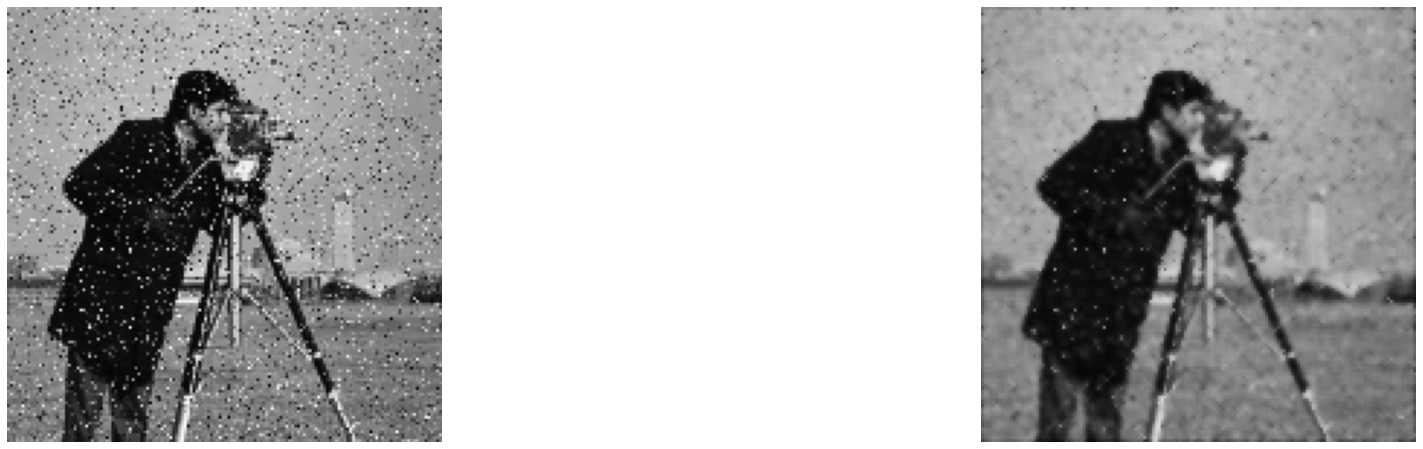

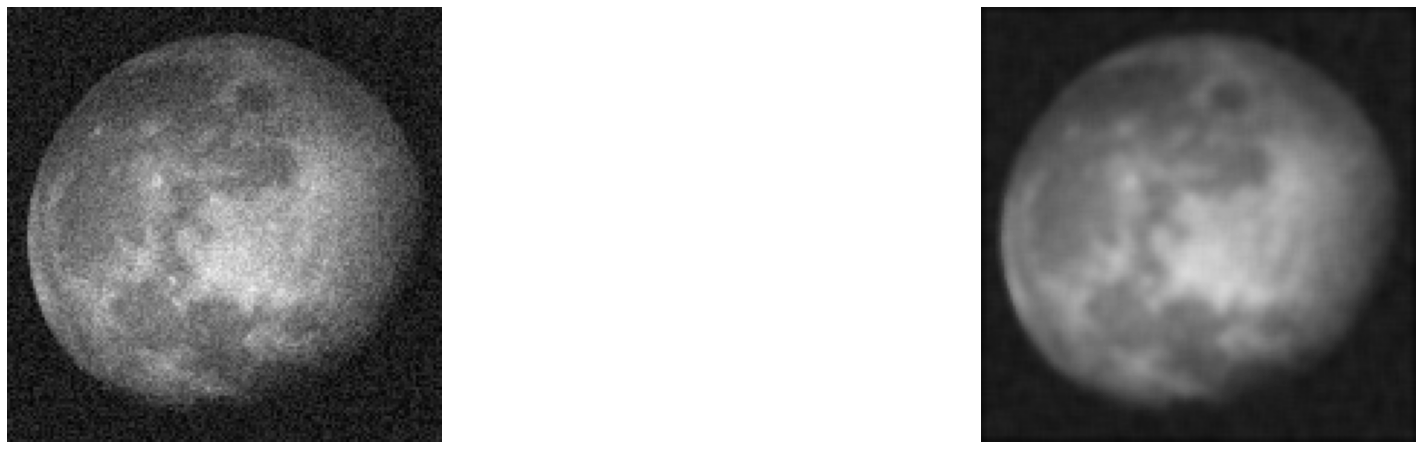

In [3]:
img1 = imageio.imread('images/moon.png')
img2 = imageio.imread('images/camera.png')
img3 = imageio.imread('images/arara.png')
img4 = imageio.imread('images/airplane.png')
img5 = imageio.imread('images/flower.png')

img1_bilateral = bilateral_filter(img2 , 3 , 150 , 100)
img2_bilateral = bilateral_filter(img1 , 5 , 50 , 100)

plt.figure(figsize=(32,8))
plt.subplot(121)
plt.imshow(img2 , cmap='gray' , vmin=0 , vmax=255)
plt.axis('off')
plt.subplot(122)
plt.imshow(img1_bilateral , cmap='gray' , vmin=0 , vmax=255)
plt.axis('off')

plt.figure(figsize=(32,8))
plt.subplot(121)
plt.imshow(img1 , cmap='gray' , vmin=0 , vmax=255)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2_bilateral , cmap='gray' , vmin=0 , vmax=255)
plt.axis('off')

## Example - Unsharp mask using the Laplacian Filter

(-0.5, 299.5, 299.5, -0.5)

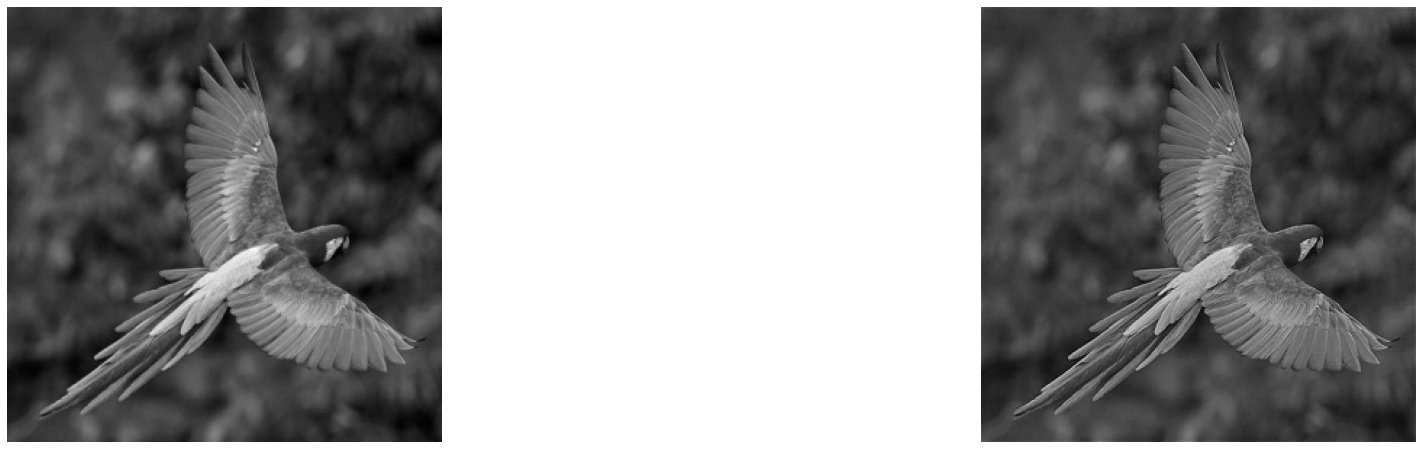

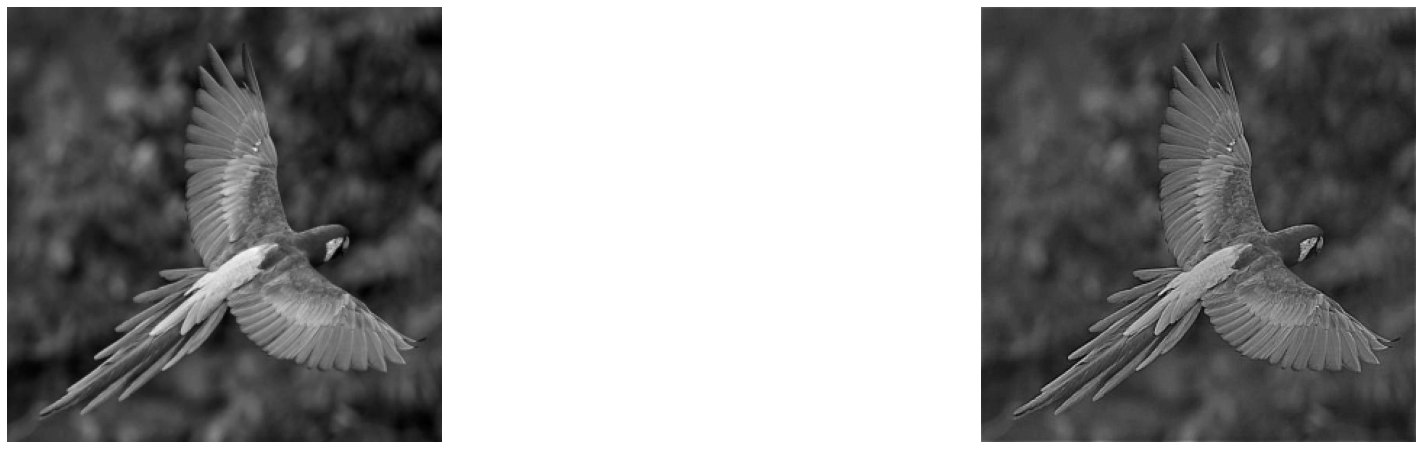

In [4]:
img1_unsharp = laplacian_filter(img3 , 0.5 , 1)
img2_unsharp = laplacian_filter(img3 , 0.75 , 2)

plt.figure(figsize=(32,8))
plt.subplot(121)
plt.imshow(img3 , cmap='gray' , vmin=0 , vmax=255)
plt.axis('off')
plt.subplot(122)
plt.imshow(img1_unsharp , cmap='gray' , vmin=0 , vmax=255)
plt.axis('off')

plt.figure(figsize=(32,8))
plt.subplot(121)
plt.imshow(img3 , cmap='gray' , vmin=0 , vmax=255)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2_unsharp , cmap='gray' , vmin=0 , vmax=255)
plt.axis('off')

## Example - Vignette Filter

(-0.5, 198.5, 170.5, -0.5)

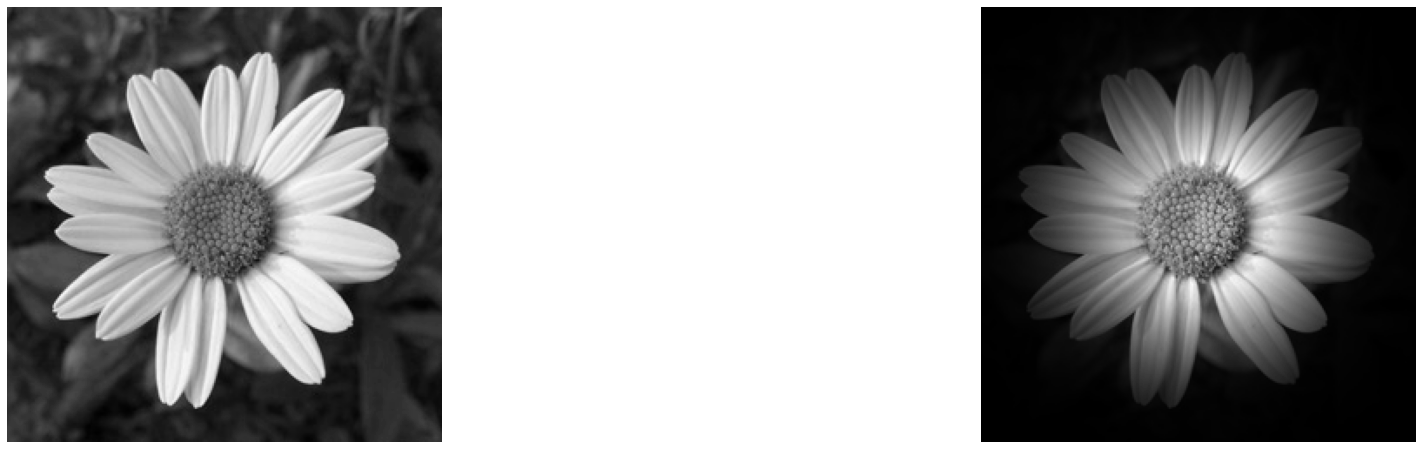

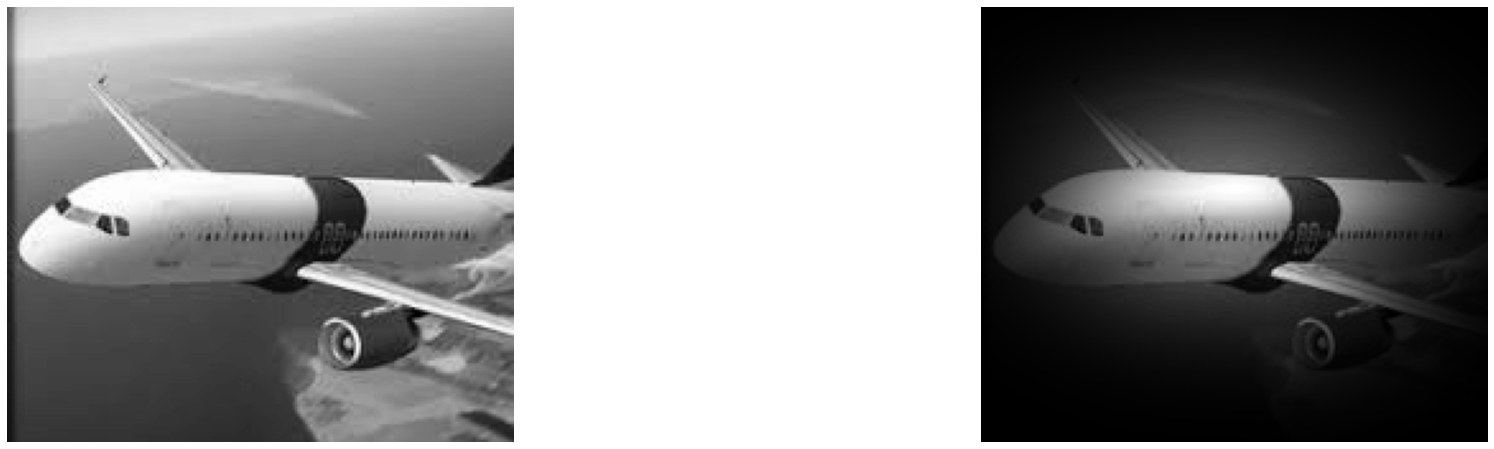

In [8]:
img1_vignete = vignetter_filter(img5 , 50 , 50)
img2_vignete = vignetter_filter(img4 , 30 , 45 )

plt.figure(figsize=(32,8))
plt.subplot(121)
plt.imshow(img5 , cmap='gray' , vmin=0 , vmax=255)
plt.axis('off')
plt.subplot(122)
plt.imshow(img1_vignete , cmap='gray' , vmin=0 , vmax=255)
plt.axis('off')

plt.figure(figsize=(32,8))
plt.subplot(121)
plt.imshow(img4 , cmap='gray' , vmin=0 , vmax=255)
plt.axis('off')
plt.subplot(122)
plt.imshow(img2_vignete , cmap='gray' , vmin=0 , vmax=255)
plt.axis('off')